# Cross entropy loss with MNIST_FULL dataset

**Objective:** In this notebook, I want to classify the full ten digits of the MNIST dataset (Q2 in "Further Research" section of Chapter 4 of the [textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). This is a key exercise to implement and understand as the lessons learned can then be extended to practically ANY classification application.

Note that this notebook follows [this earlier notebook that classified two digits from the MNIST_SAMPLE dataset using the `cross_entropy` loss function](https://rkishore.github.io/2021/02/11/mnist_basics_with_cross_entropy_loss.html). In particular, the key additional learning was to define the `batch_accuracy` function for N columns of activations from the final layer of the model.

Note that the original [MNIST dataset] (http://yann.lecun.com/exdb/mnist/) is a classic dataset of small (28x28 pixels), handwritten grayscale digits developed in the 1990s. The version we use here from fast.ai uses a standard PNG format instead of the special binary format of the original, making it easier to work with. 

### Get the basic imports out of the way

In [1]:
from fastai.vision.all import *

In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *

### Get your data ready

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

(#2) [Path('/home/igolgi/.fastai/data/mnist_png/testing'),Path('/home/igolgi/.fastai/data/mnist_png/training')]

### Enumerate and record the image paths

In [6]:
MAX_CATEGORIES = 10

In [7]:
train_imgs = [Path(str(path/'training') + '/%s/' % (i,)).ls().sorted() for i in range(MAX_CATEGORIES)]
test_imgs = [Path(str(path/'testing') + '/%s/' % (i,)).ls().sorted() for i in range(MAX_CATEGORIES)]

#### Read in the images and convert them to tensors

In [8]:
train_tensors = [[tensor(Image.open(img)) for img in train_imgs[i]] for i in range(MAX_CATEGORIES)]
test_tensors = [[tensor(Image.open(img)) for img in test_imgs[i]] for i in range(MAX_CATEGORIES)]

<AxesSubplot:>

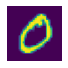

In [9]:
show_image(train_tensors[0][0])

<AxesSubplot:>

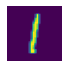

In [10]:
show_image(train_tensors[1][0])

<AxesSubplot:>

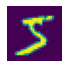

In [11]:
show_image(train_tensors[5][0])

In [12]:
stacked_train_tensors = torch.stack(train_tensors[0]).float()/255.
stacked_train_tensors.shape

torch.Size([5923, 28, 28])

In [13]:
stacked_train_tensors = [torch.stack(train_tensors[i]).float()/255. for i in range(MAX_CATEGORIES)]
stacked_test_tensors = [torch.stack(test_tensors[i]).float()/255. for i in range(MAX_CATEGORIES)]

In [14]:
stacked_train_tensors[0].shape

torch.Size([5923, 28, 28])

In [15]:
train_x = torch.cat(stacked_train_tensors); train_x.shape

torch.Size([60000, 28, 28])

So, in the training data, there are a total of 60000 images of 28x28 pixels each for the digits from 0 to 9. Let's "flatten" the 28x28 matrices corresponding to each image into one long row of 784 pixel values per image. This representation is easier to deal with as we will see later. Basically, we can then come up with a weight per pixel that has to be learnt in order to classify the ten digits accurately.

In [16]:
train_x = train_x.view(-1, 28*28); train_x.shape

torch.Size([60000, 784])

In [17]:
test_x = torch.cat(stacked_test_tensors); test_x.shape

torch.Size([10000, 28, 28])

Likewise, for the validation dataset, there are 10000 images of 28x28 pixels each for the digits from 0 to 9. Let's "flatten" the 28x28 matrices corresponding to each image into one long row of 784 pixel values per image.

In [18]:
test_x = test_x.view(-1, 28*28); test_x.shape

torch.Size([10000, 784])

Let us now create the labels for each of these images. Basically, the label for each digit is simply the integer corresponding to that digit. So, all 0 images have a 0 label, all 1 images have a 1 label and so on. 

In [19]:
train_y_list = []
for i in range(MAX_CATEGORIES):
    train_y_list += [i]*len(train_imgs[i])
len(train_y_list)

60000

In [20]:
train_y = tensor(train_y_list); train_y.shape
#train_y = tensor([1]*len(train_imgs[0]) + [0]*len(train_imgs[1])); train_y.shape

torch.Size([60000])

And there are 60000 labels, one for each training image.

Next, we use the exact same process to label the validation/test images. Note that for both the training and validation label tensor, we don't use `torch.unsqueeze` as in the [earlier notebook](https://rkishore.github.io/2021/02/11/mnist_basics_with_cross_entropy_loss.html) as we don't need it here. The labels `y` being represented by a rank-1 tensor (a vector) works just fine. In fact, you would have noticed in the [earlier notebook](https://rkishore.github.io/2021/02/11/mnist_basics_with_cross_entropy_loss.html) that we have to use `torch.squeeze` in the `batch_accuracy` function so as to get a rank-1 tensor (a vector) from a rank-2 tensor (a matrix).

In [21]:
test_y_list = []
for i in range(MAX_CATEGORIES):
    test_y_list += [i]*len(test_imgs[i])
#test_y = tensor(test_y_list).unsqueeze(1); test_y.shape
test_y = tensor(test_y_list); test_y.shape

torch.Size([10000])

As expected, there are 10000 labels, one for each validation image.

### Prepare the dataset and dataloaders

In [22]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(test_x, test_y))

In [23]:
dl = DataLoader(dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

### Define key functions

In [24]:
# The cross-entropy loss function: we take the log_softmax of the activations returned by the model, and 
# then use the nll_loss function to select the loss corresponding to the target index
def ce_loss(preds, tgts):
    preds = torch.log_softmax(preds, dim=1)
    return F.nll_loss(preds, tgts)

In [25]:
def calc_grad(xb, yb, model, loss_func):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    return loss

In [26]:
def train_epoch(model, lr, params, loss_func):
    acc_loss = []
    for xb, yb in dl:
        acc_loss.append(calc_grad(xb, yb, model, loss_func))
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()
    print("Mean loss: ", tensor(acc_loss).mean())

In [27]:
def batch_accuracy(xb,yb):
    _, preds = torch.max(xb, 1)
    correct = (preds == yb)
    return correct.float().mean()

In [28]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb,yb in valid_dl]
    #print(accs)
    return round(torch.stack(accs).mean().item(), 4)

### Test on one batch

In [29]:
x,y = dl.one_batch()

In [30]:
y

tensor([2, 9, 8, 9, 5, 7, 1, 8, 6, 9, 6, 8, 3, 5, 4, 7, 7, 7, 1, 1, 0, 9, 3, 3, 4, 7, 2, 1, 6, 5, 3, 1, 2, 4, 8, 8, 8, 7, 7, 2, 8, 8, 8, 6, 5, 4, 8, 2, 7, 7, 9, 6, 7, 8, 6, 0, 1, 6, 9, 9, 7, 9, 5, 1,
        6, 2, 3, 2, 8, 2, 8, 4, 1, 4, 8, 6, 7, 9, 1, 9, 8, 1, 2, 7, 2, 0, 6, 2, 8, 7, 8, 2, 9, 4, 6, 2, 6, 3, 4, 8, 6, 1, 5, 3, 1, 3, 7, 2, 0, 0, 1, 6, 2, 6, 1, 0, 4, 1, 1, 5, 7, 3, 9, 7, 0, 3, 8, 9,
        8, 1, 6, 6, 4, 5, 1, 8, 0, 5, 6, 5, 9, 5, 7, 5, 6, 0, 1, 8, 1, 2, 8, 9, 9, 4, 7, 4, 8, 3, 6, 4, 5, 6, 8, 5, 3, 6, 4, 3, 4, 6, 1, 5, 5, 1, 8, 7, 8, 5, 9, 6, 1, 7, 4, 7, 2, 7, 3, 1, 0, 1, 7, 2,
        9, 3, 4, 4, 5, 2, 5, 9, 1, 6, 7, 0, 3, 3, 0, 5, 7, 0, 9, 3, 5, 2, 0, 1, 2, 6, 6, 2, 0, 4, 5, 5, 3, 8, 0, 7, 6, 2, 0, 7, 5, 1, 6, 7, 5, 2, 8, 9, 2, 6, 4, 3, 2, 6, 5, 0, 3, 0, 3, 7, 1, 6, 1, 1])

In [31]:
linear_model = nn.Linear(28*28, MAX_CATEGORIES)
batch = train_x[:4]
preds = linear_model(batch); preds

tensor([[-0.2932, -0.3405,  0.3322,  0.1191, -0.0160, -0.2307,  0.3889, -0.0661,  0.3204, -0.0289],
        [-0.1252, -0.1254,  0.2319,  0.0717, -0.2982, -0.1123,  0.1948, -0.1071,  0.1214, -0.1901],
        [-0.4835, -0.3397,  0.2349,  0.1295, -0.3830, -0.2500,  0.6015, -0.4489,  0.2581,  0.0169],
        [-0.0691,  0.0671,  0.2555,  0.0100, -0.2683, -0.1499,  0.4475,  0.0905, -0.2517, -0.1111]], grad_fn=<AddmmBackward>)

In [32]:
loss = ce_loss(preds, y[:4]); loss

tensor(2.2436, grad_fn=<NllLossBackward>)

In [33]:
batch_accuracy(preds, train_y[:4])

tensor(0.)

In [34]:
linear_model = nn.Linear(28*28, MAX_CATEGORIES)
w,b = linear_model.parameters()
params = w,b
lr = 1e-2
for i in range(20):
    train_epoch(linear_model, lr, params, ce_loss)
    print("Accuracy: ", validate_epoch(linear_model))

Mean loss:  tensor(1.5714)
Accuracy:  0.8233
Mean loss:  tensor(0.9475)
Accuracy:  0.8448
Mean loss:  tensor(0.7535)
Accuracy:  0.8598
Mean loss:  tensor(0.6580)
Accuracy:  0.8696
Mean loss:  tensor(0.6007)
Accuracy:  0.8726
Mean loss:  tensor(0.5605)
Accuracy:  0.8787
Mean loss:  tensor(0.5316)
Accuracy:  0.8826
Mean loss:  tensor(0.5090)
Accuracy:  0.882
Mean loss:  tensor(0.4909)
Accuracy:  0.8832
Mean loss:  tensor(0.4762)
Accuracy:  0.8845
Mean loss:  tensor(0.4636)
Accuracy:  0.8846
Mean loss:  tensor(0.4533)
Accuracy:  0.89
Mean loss:  tensor(0.4436)
Accuracy:  0.8922
Mean loss:  tensor(0.4355)
Accuracy:  0.8929
Mean loss:  tensor(0.4281)
Accuracy:  0.892
Mean loss:  tensor(0.4220)
Accuracy:  0.8929
Mean loss:  tensor(0.4156)
Accuracy:  0.8983
Mean loss:  tensor(0.4107)
Accuracy:  0.8948
Mean loss:  tensor(0.4053)
Accuracy:  0.9013
Mean loss:  tensor(0.4009)
Accuracy:  0.9021


We see reducing training loss and increasing accuracy. This is what we want to achieve.

And, with a simple linear classifier, we get an accuracy of 90.21%! Note that the [original MNIST work from the 1990s](http://yann.lecun.com/exdb/mnist/) reports error rates of 8.4 and 12.0% so we are in the ballpark. We do use 3-channel RGB images here as compared to 1-channel grayscale images they used so this may have something to do with the difference. 

### Now, let's replace our code with PyTorch/fastai built-in functions and see if we get the same result

In [39]:
linear_model = nn.Linear(28*28, MAX_CATEGORIES) # built-in linear classifier function

In [40]:
opt = SGD(linear_model.parameters(), lr) # built-in SGD optimizer function

Let's redefine the `train_epoch` function to use the optimizer function `opt` defined above (which uses SGD inside)

In [41]:
def train_epoch(model):
    acc_loss = []
    for xb, yb in dl:
        acc_loss.append(calc_grad(xb, yb, model, ce_loss))
        opt.step()
        opt.zero_grad()
    print("Mean loss: ", tensor(acc_loss).mean())

Let's define a `train_model` function to make our life easier (as shown in the textbook).

In [42]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print("Accuracy: ", validate_epoch(model))

In [44]:
linear_model = nn.Linear(28*28, MAX_CATEGORIES)
lr = 1e-2
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

Mean loss:  tensor(1.5554)
Accuracy:  0.8134
Mean loss:  tensor(0.9509)
Accuracy:  0.8435
Mean loss:  tensor(0.7575)
Accuracy:  0.862
Mean loss:  tensor(0.6616)
Accuracy:  0.8702
Mean loss:  tensor(0.6031)
Accuracy:  0.8741
Mean loss:  tensor(0.5628)
Accuracy:  0.8771
Mean loss:  tensor(0.5339)
Accuracy:  0.8796
Mean loss:  tensor(0.5107)
Accuracy:  0.8847
Mean loss:  tensor(0.4928)
Accuracy:  0.8869
Mean loss:  tensor(0.4778)
Accuracy:  0.8887
Mean loss:  tensor(0.4650)
Accuracy:  0.889
Mean loss:  tensor(0.4542)
Accuracy:  0.8889
Mean loss:  tensor(0.4447)
Accuracy:  0.8905
Mean loss:  tensor(0.4369)
Accuracy:  0.8931
Mean loss:  tensor(0.4293)
Accuracy:  0.8951
Mean loss:  tensor(0.4230)
Accuracy:  0.8981
Mean loss:  tensor(0.4166)
Accuracy:  0.896
Mean loss:  tensor(0.4115)
Accuracy:  0.8972
Mean loss:  tensor(0.4067)
Accuracy:  0.8964
Mean loss:  tensor(0.4018)
Accuracy:  0.8943


### Using a neural network instead of a linear classifier

Let's define a simple neural network with 3 layers. The first layer is a linear classifier (like the one we saw so far) that aims to capture 30 "features". This is followed by a non-linearity (ReLU), which is followed by another linear layer that outputs MAX_CATEGORIES (ten) activations, one per category. We will use this simple neural network instead of the linear classifier, keeping all else the same. 

In other words, we use the same loss function, the same accuracy function, the same SGD optimizer but just change the underlying "network architecture".

In [48]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,MAX_CATEGORIES)
)

In [49]:
lr = 1e-2
opt = SGD(simple_net.parameters(), lr)
train_model(simple_net, 20)

Mean loss:  tensor(2.0894)
Accuracy:  0.6733
Mean loss:  tensor(1.4704)
Accuracy:  0.7968
Mean loss:  tensor(0.9518)
Accuracy:  0.846
Mean loss:  tensor(0.7077)
Accuracy:  0.861
Mean loss:  tensor(0.5910)
Accuracy:  0.8754
Mean loss:  tensor(0.5248)
Accuracy:  0.8792
Mean loss:  tensor(0.4814)
Accuracy:  0.8885
Mean loss:  tensor(0.4511)
Accuracy:  0.891
Mean loss:  tensor(0.4285)
Accuracy:  0.8944
Mean loss:  tensor(0.4110)
Accuracy:  0.8985
Mean loss:  tensor(0.3965)
Accuracy:  0.8976
Mean loss:  tensor(0.3848)
Accuracy:  0.8984
Mean loss:  tensor(0.3752)
Accuracy:  0.8989
Mean loss:  tensor(0.3664)
Accuracy:  0.9026
Mean loss:  tensor(0.3588)
Accuracy:  0.9047
Mean loss:  tensor(0.3523)
Accuracy:  0.9075
Mean loss:  tensor(0.3464)
Accuracy:  0.899
Mean loss:  tensor(0.3407)
Accuracy:  0.9087
Mean loss:  tensor(0.3357)
Accuracy:  0.9073
Mean loss:  tensor(0.3315)
Accuracy:  0.9105


**Observation**: Our code above can classify two-ten MNIST digits (just change the MAX_CATEGORIES value and re-run the notebook). Yay! We have looked at using a linear classifier as well as a simple neural net with 2 linear layers and 1 ReLU in between them. After 20 epochs, we get ~90% accuracy for both "network architectures". We use our cross-entropy loss function `ce_loss`, the `batch_accuracy` functions as well as stochastic gradient descent (SGD) as our optimizer function.

### Lets try the built-in Learner class now with our loss and accuracy functions

In [50]:
dls = DataLoaders(dl, valid_dl)

Let's define simple_net so that we start training from scratch

In [53]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,MAX_CATEGORIES)
)

In [54]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=ce_loss, metrics=batch_accuracy)

In [55]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,batch_accuracy,time
0,1.983459,1.864117,0.558300,00:00
1,1.362842,1.218018,0.757100,00:00
2,0.917346,0.824246,0.828200,00:00
3,0.698222,0.642191,0.854000,00:00
4,0.584295,0.545529,0.867800,00:00
5,0.520027,0.487446,0.878200,00:00
6,0.474387,0.448316,0.885400,00:00
7,0.443602,0.420808,0.889300,00:00
8,0.427964,0.399631,0.893100,00:00
9,0.404308,0.383699,0.895300,00:00


We get >91% batch_accuracy with the built-in Learner function using our loss function `ce_loss` and our accuracy function `batch_accuracy`. 

### Let's try the built-in cnn_learner function from fastai next

To use the built-in fastai library functions, we have to use the higher-level library functions to read in the data as tensors, split it into training and validation dataloaders, and perform any data augmentations to improve our accuracy. Now, we are starting to use the state-of-the-art instead of our own hand-written functions or their equivalents. We use the fastai `DataBlock` API to do all of the above. 

Note that the lines:
    
    item_tfms=Resize(32),
    batch_tfms=aug_transforms(size=28, min_scale=0.75)
     
implement a fastai data augmentation strategy called **presizing**.

In [56]:
mnist = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(train_name=('training'), valid_name='testing'),
                  get_y=parent_label,
                  item_tfms=Resize(32),
                  batch_tfms=aug_transforms(size=28, min_scale=0.75))

In [57]:
dls = mnist.dataloaders(path)

In [58]:
dls.train_ds

(#60000) [(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9))...]

Training dataset shows 60000 tensors corresponding to the 60000 images as expected.

In [59]:
dls.valid_ds

(#10000) [(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9)),(PILImage mode=RGB size=28x28, TensorCategory(9))...]

Validation dataset shows 10000 tensors corresponding to the 10000 images as expected.

In [60]:
x,y = dls.one_batch()

In [61]:
y

TensorCategory([1, 3, 9, 2, 1, 3, 9, 6, 6, 4, 4, 3, 6, 2, 9, 6, 4, 3, 7, 6, 3, 6, 1, 7, 4, 6, 8, 4, 8, 3, 0, 2, 9, 4, 1, 6, 6, 2, 8, 0, 5, 6, 4, 2, 7, 3, 2, 6, 4, 2, 5, 1, 2, 1, 6, 3, 8, 9, 3, 9, 1, 4, 0, 8],
       device='cuda:0')

Our default batch size is 64 so the `y` (dependent variable or labels) tensor shows 64 rows. Each row is a single integer between 0 and 9, representing the ten possible digits. 

Let's use the built-in `show_batch` function to look at the data.

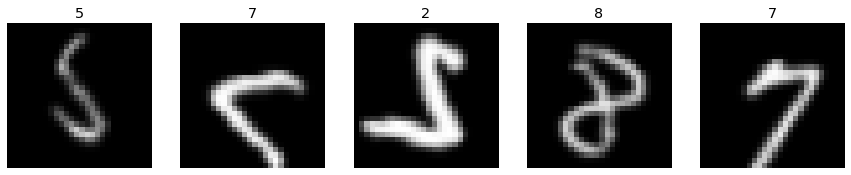

In [62]:
dls.show_batch(nrows=1, ncols=5)

### Using the cnn_learner with the resnet18 network, cross-entropy loss, and the built-in accuracy function

In [63]:
learn = cnn_learner(dls, resnet18, pretrained=False, loss_func=F.cross_entropy, metrics=accuracy)

Let's use the built-in [learning rate finder](https://arxiv.org/abs/1506.01186) to find a good learning rate to use while training.

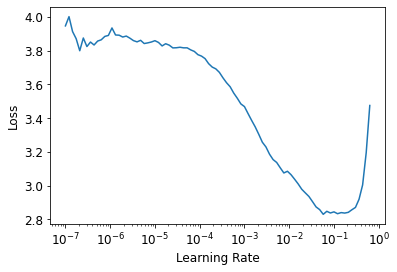

In [64]:
lr_min, lr_steep = learn.lr_find()

In [65]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 5.75e-03, steepest point: 2.09e-03


We can see in the plot above that the loss does not start decreasing till around 1e-4. Nothing really happens from 1e-7 to 1e-4. Beyond 1e-4, it decreases till around 1e-1, beyond which it starts increasing. We don't want a learning rate greater than 1e-1.

The number `lr_min` tells us the order-of-magnitude lower learning rate corresponding to the learning rate where the minimum loss was achieved. The number `lr_steep` tells us the last learning rate where the loss was clearly decreasing. The textbook asks us to pick one of these values or a learning rate around these values as a rule-of-thumb to pick a good learning rate. We pick lr=3e-3.

In [66]:
learn.fine_tune(5, base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.419033,0.938879,0.683900,01:16


epoch,train_loss,valid_loss,accuracy,time
0,0.522387,0.301600,0.904700,01:25
1,0.312611,0.182286,0.943000,01:26
2,0.226973,0.145478,0.951900,01:25
3,0.171017,0.097725,0.969800,01:25
4,0.154143,0.082914,0.973600,01:24


Wow! Just like that, we are at 97.3% accuracy. Let's save this model for future use/training/refining. Note that the world record for MNIST right now is 99.75% accuracy (https://www.kaggle.com/c/digit-recognizer/discussion/61480). We can try to achieve higher accuracy by training for longer and also using discriminative learning rates. More on that later.

In [67]:
learn.save("mnist-full-resnet18-best")

Path('models/mnist-full-resnet18-best.pth')

#hide
### Model Interpretation

#hide
Let's now explore fastai's built-in functions to interpret how our model does. Note that the textbook says that loss functions are very hard to interpret as they designed for computers to differentiate and optimize, and not something that people can understand. This is what metrics (such as accuracy are for). In this case, our accuracy is looking pretty good already but where are we making mistakes? 

We can use a `confusion matrix` to see where our model is doing well and where its doing badly.

In [73]:
#hide
interp = ClassificationInterpretation.from_learner(learn)

In [74]:
#hide
interp.plot_confusion_matrix()

AssertionError: ==:
100000
10000

In [75]:
#hide
interp.most_confused(min_val=5)

AssertionError: ==:
100000
10000

In [ ]:
### Ok, back to improving the model